In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display



In [2]:
class GazeDetector:
    def __init__(self):
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
        self.mp_drawing = mp.solutions.drawing_utils

    def get_landmark_coordinates(self, landmarks, index, image_shape):
        height, width, _ = image_shape
        x = int(landmarks[index].x * width)
        y = int(landmarks[index].y * height)
        return (x, y)

    def get_gaze_direction(self, landmarks, image_shape):
        left_eye = self.get_landmark_coordinates(landmarks, 33, image_shape)
        right_eye = self.get_landmark_coordinates(landmarks, 263, image_shape)
        nose_tip = self.get_landmark_coordinates(landmarks, 1, image_shape)
        
        eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
        nose_to_eye_vector = np.array([eye_center[0] - nose_tip[0], eye_center[1] - nose_tip[1]])
        
        if nose_to_eye_vector[0] > 20:
            return "Looking Left"
        elif nose_to_eye_vector[0] < -20:
            return "Looking Right"
        else:
            return "Looking Forward"

    def detect_gaze(self, frame):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.face_mesh.process(frame_rgb)

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                self.mp_drawing.draw_landmarks(frame, face_landmarks, self.mp_face_mesh.FACEMESH_CONTOURS, 
                                               self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
                                               self.mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=1, circle_radius=1))
                gaze_direction = self.get_gaze_direction(face_landmarks.landmark, frame.shape)
                return gaze_direction, frame

        return "Face Not Detected", frame


In [3]:
class CheatingIntensityPlotter:
    def __init__(self):
        self.times = []
        self.intensities = []
        plt.ion()  # Interactive mode on
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot([], [], label='Cheating Intensity')
        self.ax.set_ylim(0, 10)
        self.ax.set_xlabel('Time')
        self.ax.set_ylabel('Cheating Intensity')
        self.ax.set_title('Cheating Intensity Over Time')
        self.ax.legend()
        display(self.fig)

    def update_plot(self, time, intensity):
        self.times.append(time)
        self.intensities.append(intensity)
        self.line.set_data(self.times, self.intensities)
        self.ax.set_xlim(0, max(10, time))
        self.ax.figure.canvas.draw()

    def show_plot(self):
        plt.ioff()
        plt.show()


I0000 00:00:1722512843.161758 22890794 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


<IPython.core.display.Javascript object>


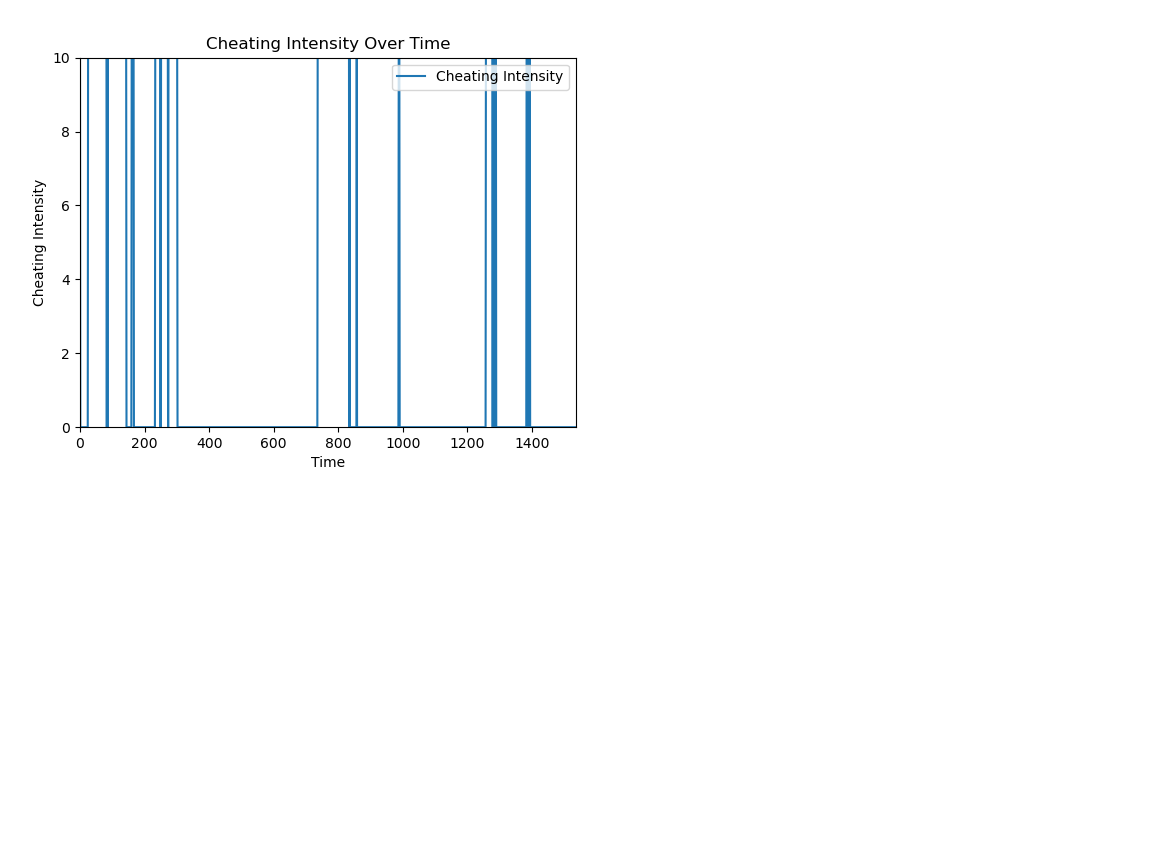

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1722512843.178177 22891047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722512843.186299 22891047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


<IPython.core.display.Javascript object>


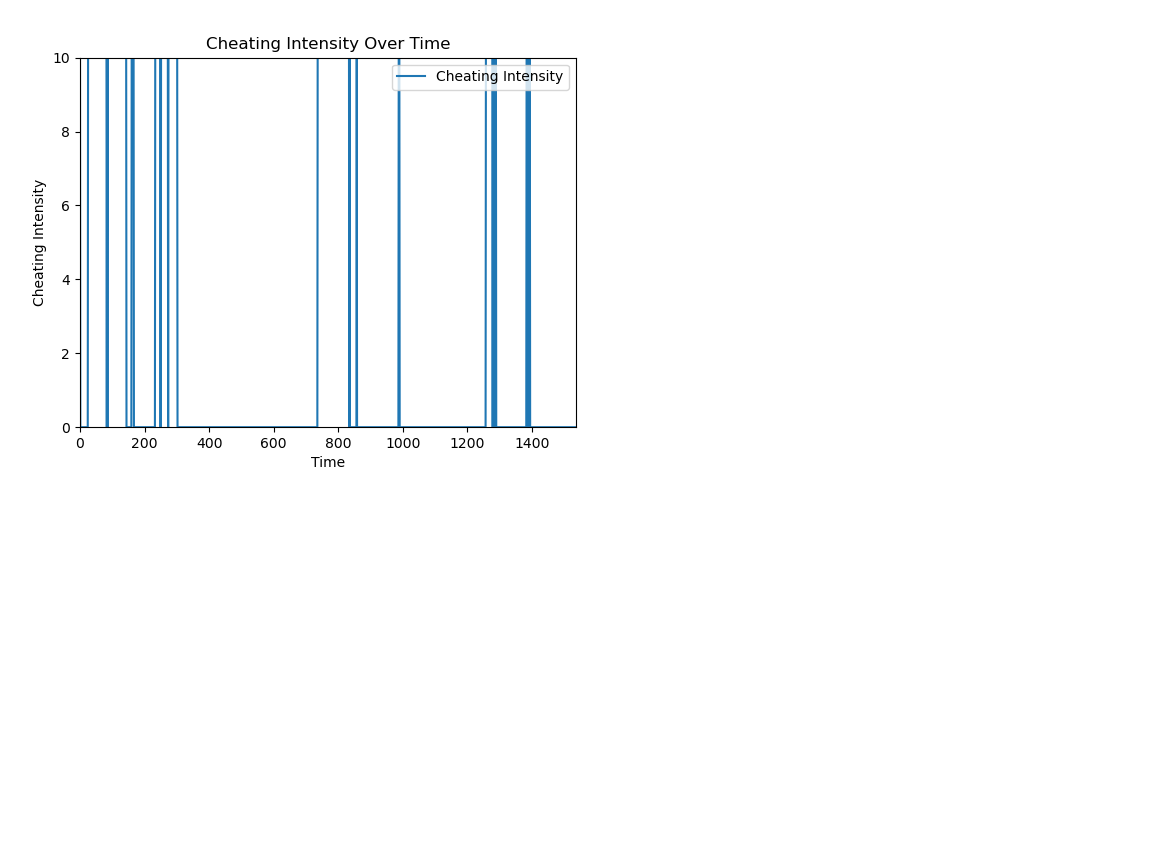

/Users/prathamhandique/Downloads/anaconda3/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
%matplotlib notebook

gaze_detector = GazeDetector()
plotter = CheatingIntensityPlotter()

cap = cv2.VideoCapture(0)
time_step = 0

try:
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        gaze_direction, frame_with_landmarks = gaze_detector.detect_gaze(frame)
        cheating_intensity = 10 if gaze_direction != "Looking Forward" else 0

        plotter.update_plot(time_step, cheating_intensity)
        time_step += 1

        cv2.putText(frame_with_landmarks, gaze_direction, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.imshow('Gaze Detection', frame_with_landmarks)

        if cv2.waitKey(5) & 0xFF == 27:
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
    plotter.show_plot()
